# Salary Prediction
This project predicts salary based on job descriptions. This notebook shows my thought process from data scrubbing, to EDA, and finally model fitting. Final clean code is in separate python script.

## Features:
1. jobId
2. companyId
3. jobType
4. degree
5. major
6. industry
7. yearsExperience
8. milesFromMetropolis
9. salary

## Import Libraries

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# set display to 3 decimal max
pd.set_option('precision', 3)

## Load data

In [3]:
# unzip data file
zipfile_path = os.path.join("..", "SalaryPredictions.zip")
zipfile_ref = zipfile.ZipFile(zipfile_path, 'r')
zipfile_ref.extractall("..")
zipfile_ref.close()

print("Files in data zip file:", os.listdir(os.path.join("..", "data")))

Files in data zip file: ['test_features.csv', 'train_features.csv', 'train_salaries.csv']


In [4]:
# load train and test feature data and train target data
test_df = pd.read_csv(os.path.join("..", "data", "test_features.csv"), header=0)
train_df = pd.read_csv(os.path.join("..", "data", "train_features.csv"), header=0)
train_df['salary'] = pd.read_csv(os.path.join("..", "data", "train_salaries.csv"), header=0)['salary']

## Examine data
### Training set

In [5]:
print(train_df.info())
display(train_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 68.7+ MB
None


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


### Test set

In [6]:
print(test_df.info())
display(test_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
None


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


## Clean data
Before we dive in to data analysis, we should perform basic cleaning. Look for:
1. Any missing values (np.None or np.NaN) in entire training and testing set
    * from train_df.info() and test_df.info(), there's no null cell
2. Any duplicated samples in training set
3. Any invalid yearsExperience (yearsExperience <= 0) in training set
4. Any invalid milesFromMetropolis (milesFromMetropolis < 0) in training set
5. Any invalid salary (salary < 0) in training set

In [7]:
print("Any duplicated rows in training set?", train_df.duplicated().sum())
print("Any invalid yearsExperience in training set?", train_df.yearsExperience.lt(0).sum())
print("Any invalid yearsExperience in test set?", test_df.yearsExperience.lt(0).sum())
print("Any invalid milesFromMetropolis in training set?", train_df.milesFromMetropolis.lt(0).sum())
print("Any invalid milesFromMetropolis in test set?", test_df.milesFromMetropolis.lt(0).sum())
print("Any invalid salary in training set?", train_df.salary.le(0).sum())

Any duplicated rows in training set? 0
Any invalid yearsExperience in training set? 0
Any invalid yearsExperience in test set? 0
Any invalid milesFromMetropolis in training set? 0
Any invalid milesFromMetropolis in test set? 0
Any invalid salary in training set? 5


Need to drop jobs with salary <= 0. Since we have 1,000,000 samples, we have enough data to handle removing those jobs.

In [8]:
train_df = train_df.drop(train_df.index[train_df.salary.le(0)])
print("Training set now has shape:", train_df.shape)

Training set now has shape: (999995, 9)


In [9]:
train_df.set_index('jobId', inplace=True)
test_df.set_index('jobId', inplace=True)

## Explore data
Now that we've done the basic cleaning, let's look at each feature one by one and generate some statistics reports to further analyze our data.

### Salary
First look at the distribution of salary in market:

count    999995.000
mean        116.062
std          38.717
min          17.000
25%          88.000
50%         114.000
75%         141.000
max         301.000
Name: salary, dtype: float64

<AxesSubplot:xlabel='salary'>

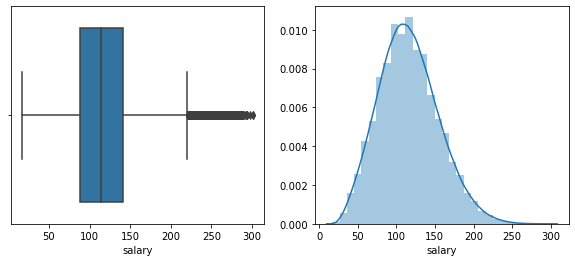

In [10]:
# show salary statistics
display(train_df.salary.describe())

# plot boxplot and histogram
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(train_df.salary)
plt.subplot(1, 2, 2)
sns.distplot(train_df.salary, bins=30)

The distribution is very Gaussian like and slighty positive skewed. Must be because of the outliers with salary over the upper bound of salary distribution. Use IQR rule to identify those jobs:

In [11]:
# calculate Q1, Q3 and upper bound of salary
Q1 = train_df.salary.quantile(0.25)
Q3 = train_df.salary.quantile(0.75)
upper_bound = Q3 + 1.5 * (Q3 - Q1)

# show first 10 jobs that has salary more than upper bound
display(train_df[train_df.salary.gt(upper_bound)].head(10))

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
JOB1362684408653,COMP32,CEO,DOCTORAL,ENGINEERING,FINANCE,23,11,247
JOB1362684408673,COMP37,CFO,HIGH_SCHOOL,NONE,FINANCE,24,20,229
JOB1362684408898,COMP24,CTO,DOCTORAL,BUSINESS,FINANCE,5,46,232
JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225


In the list, most jobs are for chief officer positions and requires advanced degree. JOB1362684408909 is entry level position but asks for at least master degree in computer science, and later we'll see that oil industry has relatively high salary compare to other industries. All and all, the outliers make sense and we'll keep them in our data.

### Company ID
In real-life, if a company is well-known or an international organization, the salary is likely to be higher than local startups. We can generate a statistics report to find out which company pays more in general. Since there are 63 companies, let's randomly select some companies and see their statistics:

In [12]:
def group_values(feature, values):
    first_one = True
    for value in values:
        if first_one:
            groups = train_df[[feature, 'salary']][train_df[feature] == value]
            first_one = False
        else:
            group = train_df[[feature, 'salary']][train_df[feature] == value]
            groups = pd.concat([groups, group], axis=0)
    return groups

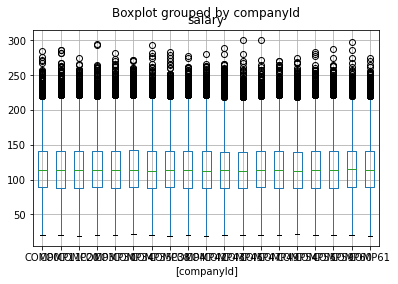

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP34,15809.0,116.402,38.911,22.0,89.0,114.0,142.0,272.0
COMP61,15822.0,116.319,38.544,19.0,89.0,114.0,141.0,275.0
COMP49,15779.0,116.270,38.912,20.0,88.0,114.0,141.0,271.0
COMP60,15799.0,116.236,38.253,20.0,89.0,115.0,141.0,298.0
COMP4,15918.0,116.231,38.945,20.0,88.0,114.0,141.0,278.0
COMP38,15819.0,116.199,38.843,19.0,89.0,114.0,141.0,283.0
COMP3,16028.0,116.199,38.479,20.0,89.0,114.0,141.0,294.0
COMP11,31744.0,116.113,38.623,20.0,88.0,114.0,141.0,286.0
COMP0,15666.0,115.964,38.605,20.0,89.0,114.0,141.0,285.0


In [13]:
# randomly select 20 companies
companies = train_df.companyId.unique()
pick_n_companies = 20
rand_companies = companies[np.random.randint(1, len(companies), pick_n_companies)]

# show boxplot
sorted_companies = group_values('companyId', rand_companies)
sorted_companies.boxplot(by='companyId')
plt.show()

# show statistics
display(sorted_companies.groupby(['companyId']).salary.describe().sort_values(by='mean', ascending=False))

Observations:
1. Similar distribution
2. Average salary varies a little
    * Average salary span between 115-117
3. Similar deviation
4. The 25%, 50%, and 75% quantile are almost the same between companies

Salary distributions are very identical that no company particularly stands out with higher or lower wage.

### Job Types
There are 8 types of job: CEO, CFO, CTO, JANITOR, JUNIOR, MANAGER, SENIOR and VICE_PRESIDENT.

It's reasonable to assume the chief positions offers much higher than JANITOR and JUNIOR. But will it be linear increase? Or exponential? Let's check the statistics

In [14]:
def show_statistics_and_boxplot(feature):
    # statistics
    display(train_df.groupby([feature]).salary.describe().sort_values(by='mean', ascending=False))
    
    # boxplot
    train_df[[feature, 'salary']].boxplot(by=feature)

,count,mean,std,min,25%,50%,75%,max
jobType,,,,,,,,
CEO,124778.0,145.311,34.424,55.0,120.0,142.0,167.0,298.0
CTO,125045.0,135.481,33.091,51.0,111.0,132.0,156.0,301.0
CFO,124369.0,135.459,33.069,51.0,111.0,132.0,156.0,301.0
VICE_PRESIDENT,125234.0,125.369,31.956,44.0,102.0,122.0,146.0,272.0
MANAGER,125120.0,115.369,30.834,37.0,93.0,112.0,135.0,270.0
SENIOR,125886.0,105.488,30.070,31.0,83.0,102.0,124.0,258.0
JUNIOR,124592.0,95.333,29.247,23.0,74.0,92.0,114.0,248.0
JANITOR,124971.0,70.813,24.643,17.0,52.0,68.0,86.0,189.0


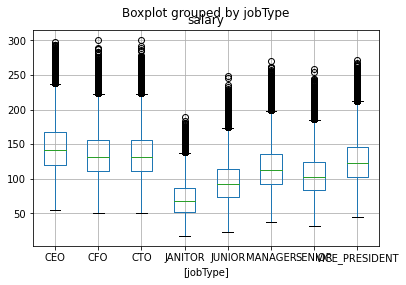

In [15]:
show_statistics_and_boxplot('jobType')

Looks like there's some rules to follow:
1. Jobs areevenly distributed. Each job type has 124,000~126,000 sample
2. The spectrum of average salary is the widest among all featuers
    * Average salary ranges from 145 to 70
3. CFO and CTO offer same salary and have same distribution
4. The average salary ranking is: CEO > CFO = CTO > VP > MANAGER > SENIOR > JUNIOR >> JANITOR
5. The deviation decreases with average salary
6. All positions are slightly positive skewed Gaussian distribution.

Some data transformation is needed to emphasize the rules in jobType vs. salary. 

To visualize more on the skewness, use histograms, skewness, and number of outliers|:

In [16]:
def show_hist_skewness_outliers(feature, plotsize):
    features = train_df[feature].unique()
    plt.figure(figsize = (14, 6))

    # print histogram
    for i in range(len(features)):
        plt.subplot(plotsize[0], plotsize[1], i+1)
        plt.hist(train_df.salary[train_df[feature] == features[i]])
        plt.title(features[i])
    plt.show()
    
    # show skewness
    display(train_df.groupby([feature]).salary.skew().sort_values(ascending=False))
    
    # show number of outliers
    Q1 = train_df.groupby([feature]).salary.quantile(0.25)
    Q3 = train_df.groupby([feature]).salary.quantile(0.75)
    upper_bound = Q3 + 1.5 * (Q3 - Q1)
    outliers = train_df.groupby([feature]).apply(lambda x: (x.salary.values > upper_bound[x[feature]]).sum())
    display(outliers.sort_values(ascending=False))

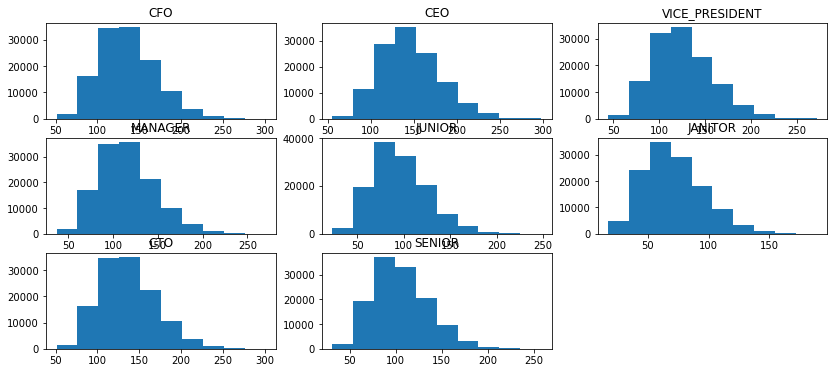

jobType
JANITOR           0.634
JUNIOR            0.594
SENIOR            0.556
MANAGER           0.552
VICE_PRESIDENT    0.527
CFO               0.515
CTO               0.512
CEO               0.491
Name: salary, dtype: float64

jobType
JANITOR           1365
SENIOR            1330
JUNIOR            1285
CFO               1234
CTO               1211
MANAGER           1192
CEO               1134
VICE_PRESIDENT    1074
dtype: int64

In [17]:
show_hist_skewness_outliers('jobType', (3,3))

This backs up our previous assumption of positive skewness. As shown in skew table, the skewness are all positive and relatively small, and most histograms slightly lean toward left. In addition, with lower position, skewness and outliers increases. 

My guessing would be that lower positions usually have more room to negotiate for more salary due to other factors, such as world class company might offer more for the same position than local startups, or people with prior experience in the industry tends to be offered more than university graduates. And people interviewing for higher position might not be for the money, so the positions tends to offer standard salary. Thus the salaries for lower positions seems to rely more on other features than higher positions.

### Degree
There are 5 types of degree: BACHLORS, DOCTORAL, HIGH_SCHOOL, MASTERS, and NONE

I expect that more professional position asks for higher educatation, so jobs requiring DOCTORAL degree might offer much higher than HIGH SCHOOL graduated. But will it be the same for DOCTORAL vs. MASTER degree? How much of a gap in salary will it be?

,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
DOCTORAL,175362.0,135.491,35.791,45.0,109.0,132.0,158.0,301.0
MASTERS,175310.0,130.506,35.400,38.0,105.0,127.0,153.0,301.0
BACHELORS,175495.0,125.455,35.043,35.0,100.0,122.0,148.0,294.0
HIGH_SCHOOL,236975.0,101.921,36.113,18.0,75.0,99.0,125.0,260.0
NONE,236853.0,98.177,34.915,17.0,72.0,95.0,121.0,254.0


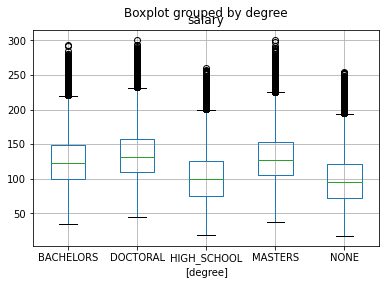

In [18]:
show_statistics_and_boxplot('degree')

Observations:
1. Number of jobs not asking for a degree is almost the same as asking for HIGH_SCHOOL degree.
2. Number of jobs asking for BACHELORS, MASTERS, and DOCTORAL are almost the same.
3. Jobs asking for HIGH_SCHOOL degree offer almost the same salary as NONE. 
4. Jobs asking for HIGH_SCHOOL degree or NONE offer much less than BACHELORS and above. 
5. Distribution for BACHELORS, MASTERS, and DOCTORAL shifts and narrows in same rate.
6. The average salary ranking is: DOCTORAL > MASTERS > BACHELORS >> HIGH_SCHOOL > NONE.
7. Except HIGH_SCHOOL, the ranking of deviation is the same as average salary
    * HIGH_SCHOOL has highest deviation
    * Maybe some jobs are intern positions that allow students to continue higher education while working, thus the salary is negotiable judging from their potential
    * Maybe other jobs are general labor jobs that don't require any professional knowledge, thus paid less
8. All degree are Gaussian distributed. And maybe positively skewed.

Looks like data can be seperated to two groups:
1. NONE and HIGH_SCHOOL: more job opening but lower offer
2. BACHELORS, MASTERS, DOCTORAL: less job openings and higher offer

Use average salary as encoder can emphasize this finding.

Again, let's verify the Gaussian distribution with histograms, skewness, and outliers.

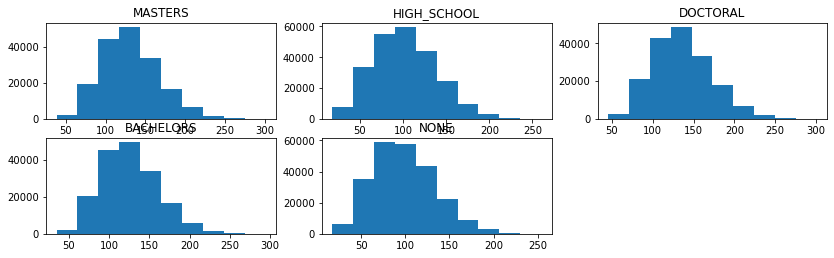

degree
MASTERS        0.468
NONE           0.465
BACHELORS      0.462
DOCTORAL       0.457
HIGH_SCHOOL    0.413
Name: salary, dtype: float64

degree
NONE           1724
HIGH_SCHOOL    1632
MASTERS        1572
DOCTORAL       1537
BACHELORS      1440
dtype: int64

In [19]:
show_hist_skewness_outliers('degree', (3,3))

As expected, it's Gaussian and positive skewed. 

It's interesting how HIGH_SCHOOL degree is skewed the least but at the same time has so many outliers, it's also offered second to least, suggesting that jobs requiring HIGH_SCHOOL have narrower spectrum of salary in general compare to other degrees.

### Major
There are 9 majors: BIOLOGY, BUSINESS, CHEMISTRY, COMPSCI (computer science), ENGINEERING, LITERATURE, MATH, NONE, and PHYSICS

I expect the technical (ENGINEERING and COMPSCI) and BUSINESS major might be offered more than pure science (BIOLOGY, CHEMISTRY, MATH, PHYSICS) and LITERATURE major since they're more practical (eg. designing product, analyzing market trend, etc.) and less theoratical or economic (eg. research papers, studying Shakespeare, etc.).

In [20]:
train_df.groupby(['major']).size()

major
BIOLOGY         58379
BUSINESS        58518
CHEMISTRY       58875
COMPSCI         58382
ENGINEERING     58594
LITERATURE      58684
MATH            57800
NONE           532353
PHYSICS         58410
dtype: int64

This features has noticable imbalanced data. More than half of the job offerings don't look at applicant's major (NONE), hance everyone can apply. But this raises some questions:
* Does it reflect on salary? 
* If the major is irrelevent, do those jobs have lower wage because it's not professional? 
    * For example, workers at warehouse or clark at supermarket might not need be any major to work.
* Does it suggest us that the major doesn't provide valueable information since so many jobs don't require any? 
    * Drop this feature?
    * Merge it with other features?
* Any relationship with other features?
    * For example, are OLD and SERVICE industry willing to hire more NONE major employees than WEB or FINANCE?
    * For example, is employee likely to be paid more with higher education in any major?

Some questions call for correlation matrix that will be shown later. Let's check the statistics report first.

,count,mean,std,min,25%,50%,75%,max
major,,,,,,,,
ENGINEERING,58594.0,138.441,38.179,41.0,111.0,135.0,163.0,301.0
BUSINESS,58518.0,135.649,37.007,40.0,109.0,132.0,159.0,294.0
MATH,57800.0,133.322,35.539,39.0,107.0,130.0,156.0,280.0
COMPSCI,58382.0,132.076,34.777,41.0,107.0,129.0,154.0,286.0
PHYSICS,58410.0,130.372,34.957,38.0,105.0,127.0,153.0,293.0
CHEMISTRY,58875.0,129.072,34.832,40.0,104.0,126.0,151.0,282.0
BIOLOGY,58379.0,127.933,34.820,35.0,103.0,125.0,150.0,285.0
LITERATURE,58684.0,124.423,33.576,37.0,100.0,122.0,146.0,271.0
NONE,532353.0,102.584,36.136,17.0,76.0,100.0,126.0,270.0


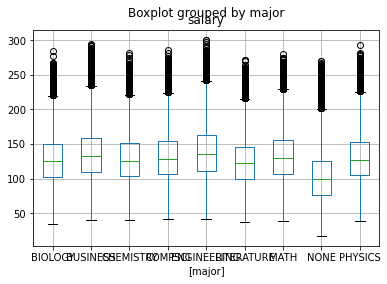

In [21]:
show_statistics_and_boxplot('major')

1. NONE obviously has lower distribution than others by great amount.
2. The average salary ranking is: ENGINEERING > BUSINESS > MATH > COMPSCI > PHYSICS > CHEMISTRY > BIOLOGY > LITERATURE >> NONE
3. BUSINESS and ENGINEERING have larger deviation
4. LITERATURE has smallest deviation
5. Ranking of deviation is similar to mean, except NONE has higher deviation
    * Lower paid jobs usually offers the standard salary
    * Higher paid jobs depends more on other factors, thus have wider range of salary
    * There can be various jobs that don't require any major, thus it also heavily depends on other features
6. Gaussian distributed and skew to positive

This verifies our initial guessing that jobs with no major requirement might be less professional and thus paid less. But consider the imbalanced data, it's too early to assume all jobs not requiring major pay less since we're not sure if there are other factors influencing the salary. More details in correlation matrix later.

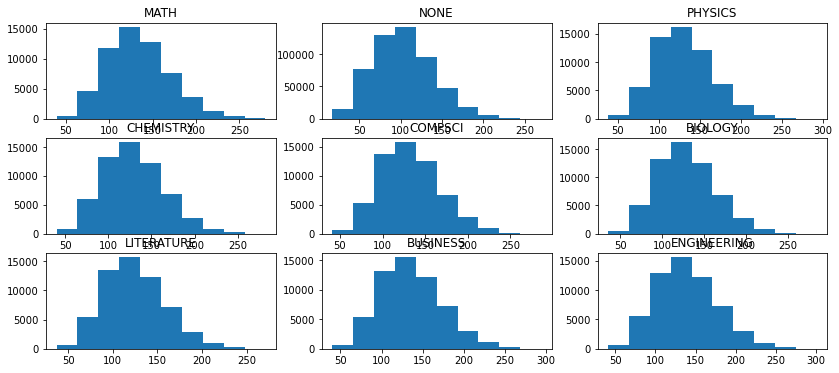

major
BUSINESS       0.458
COMPSCI        0.453
LITERATURE     0.447
PHYSICS        0.444
MATH           0.437
ENGINEERING    0.430
CHEMISTRY      0.430
BIOLOGY        0.422
NONE           0.422
Name: salary, dtype: float64

major
NONE           3760
COMPSCI         532
CHEMISTRY       525
BIOLOGY         522
BUSINESS        518
MATH            470
LITERATURE      468
ENGINEERING     468
PHYSICS         462
dtype: int64

In [22]:
show_hist_skewness_outliers('major', (3,3))

Compare to other features like jobType, all majors are skewed at similar rate. Notice that NONE has many outliers, but considering half of data requires NONE, the distribution is evened out and thus doesn't skew that much.

### Industry
There are 7 types of industry: AUTO (automobile), EDUCATION, FINANCE, HEALTH, OIL, SERVICE, and WEB

I expect FINANCE and WEB pays relatively higher and SERVICE pays lower.

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
OIL,142770.0,130.954,38.529,37.0,103.0,128.0,156.0,301.0
FINANCE,142866.0,130.748,38.320,36.0,103.0,128.0,156.0,294.0
WEB,143205.0,121.645,38.166,31.0,94.0,119.0,146.0,290.0
HEALTH,142755.0,115.736,36.865,28.0,89.0,114.0,140.0,275.0
AUTO,142941.0,109.435,36.092,25.0,84.0,108.0,133.0,264.0
SERVICE,142639.0,104.447,35.578,22.0,79.0,103.0,128.0,256.0
EDUCATION,142819.0,99.448,35.110,17.0,75.0,98.0,122.0,253.0


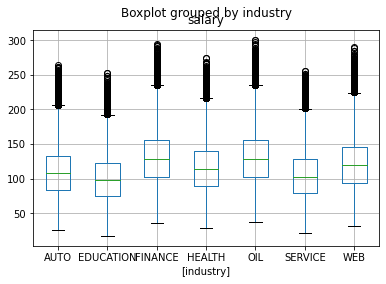

In [23]:
show_statistics_and_boxplot('industry')

Findings:
1. Each industry has around 142,800 openings.
2. FINANCE and OIL(!) have highest wage and most stretched deviation
3. FINANCE and OIL have the same distribution
4. The ranking of average salary is: FINANCE = OIL > WEB > HEALTH > AUTO > SERVICE > EDUCATION
5. The ranking of deviation is the same as average salary
    * There's a significant drop between WEB and HEALTH
    * Is there any relationship between group:(OIL, FINANCE, WEB) and group:(HEALTH, AUTO, SERVICE, EDUCATION)?
6. Gaussian distribution and positive skew

Let's look at the salary histograms and other details.

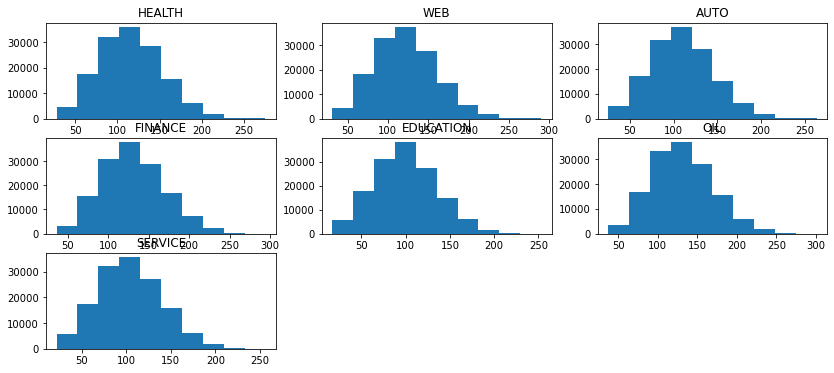

industry
OIL          0.359
WEB          0.348
FINANCE      0.345
AUTO         0.323
HEALTH       0.321
SERVICE      0.315
EDUCATION    0.304
Name: salary, dtype: float64

industry
EDUCATION    1070
WEB          1024
OIL           940
AUTO          916
FINANCE       867
SERVICE       859
HEALTH        830
dtype: int64

In [24]:
show_hist_skewness_outliers('industry', (3,3))

The skewness is smallest in all features. Similar to the deviations, there's a gap in skewness between group:(OIL, WEB, FINANCE) and group:(AUTO, HEALTH, SERVICE, EDUCATION). EDUCATION is the least skewed but has most outliers, suggesting that most positions offer merket standard salary and has narrower salary spectrum.

### Years of Experience
Span from 0 to 24 years. Let's select a few and see their distributions.

I expect the more years of experience a job asks, the more it pays. But is there a plateau? Is the relationship linear?

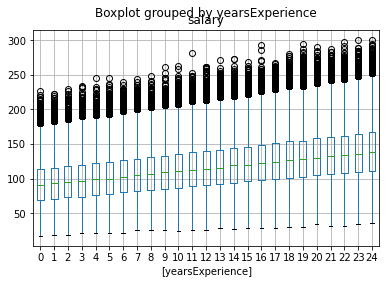

In [25]:
# select random years and plot boxplot
years = np.arange(24+1)
sorted_years = group_values('yearsExperience', years)
sorted_years.boxplot(by='yearsExperience')
plt.show()

As expected:
1. The yearsExperience and average salary have linear relationship
2. The deviation increases with average salary
3. Gaussian distribution and positive skew

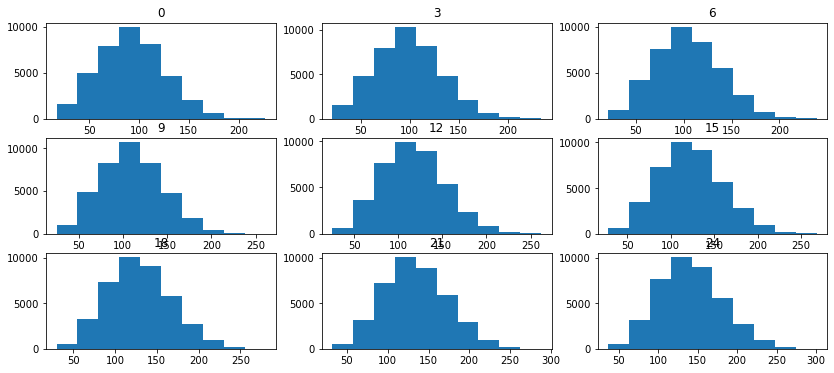

yearsExperience
0     0.232
3     0.258
6     0.240
9     0.247
12    0.288
15    0.268
18    0.276
21    0.283
24    0.298
Name: salary, dtype: float64

In [26]:
years= np.arange(0, 24+1, 3)
plt.figure(figsize = (14, 6))

for i in range(len(years)):
    plt.subplot(3, 3, i+1)
    plt.hist(train_df.salary[train_df.yearsExperience == years[i]])
    plt.title(years[i])
plt.show()

train_df.groupby(['yearsExperience']).salary.skew()[years]

The skewness is the smallest of all features and skews at similar rate. Overall, the skewness increases with yearsExperience.

And to show the linear relationship, here's the plot of yearsExperience vs. average salary.

,count,mean,std,min,25%,50%,75%,max
yearsExperience,,,,,,,,
0,39839.0,91.874,32.384,17.0,69.0,91.0,113.5,227.0
3,40190.0,98.093,33.026,21.0,74.0,97.0,120.0,234.0
6,40094.0,103.924,33.709,21.0,80.0,103.0,127.0,239.0
9,40235.0,110.106,34.494,25.0,85.0,109.0,133.0,261.0
12,39467.0,116.342,35.495,25.0,91.0,114.0,140.0,262.0
15,40312.0,121.904,36.668,28.0,96.0,120.0,146.0,268.0
18,40088.0,128.431,37.858,30.0,101.0,127.0,154.0,280.0
21,39759.0,134.002,38.904,32.0,106.0,132.0,160.0,288.0
24,39860.0,140.131,40.101,36.0,111.0,138.0,167.0,301.0


<AxesSubplot:xlabel='yearsExperience'>

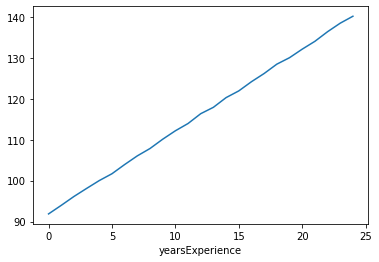

In [27]:
# select random years and show statistics
years = np.arange(0, 24+1, 3)
sorted_years = group_values('yearsExperience', years)
display(sorted_years.groupby(['yearsExperience']).salary.describe())

# plot yearsExperience vs salary
train_df.groupby(['yearsExperience']).salary.mean().plot(x='yearsExperience', y='salary')

It's a slope of 2 and offset 90 linear relationship, thus we can assume yearsExperience is an independent feature.
### Miles from metropolis
Span from 0 to 99 miles. Like yearsExperience, let's select a few and see their distributions.

I expect companies having offices in metropolis are likely to have higher net worth, thus the closer to metropolis, the more it pays. Again, is there a plateau? Is the relationship linear?

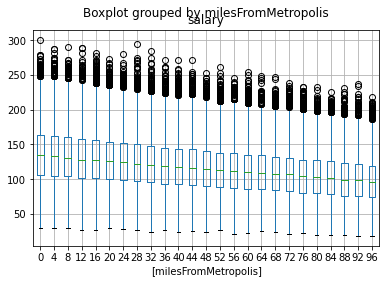

In [28]:
# select random miles
miles= np.arange(0, 99+1, 4)
sorted_miles = group_values('milesFromMetropolis', miles)
sorted_miles.boxplot(by='milesFromMetropolis')
plt.show()

Observations:
1. It's a inverse linear relationship
2. Deviation decreases with average salary
3. Gaussian distribution and positive skew

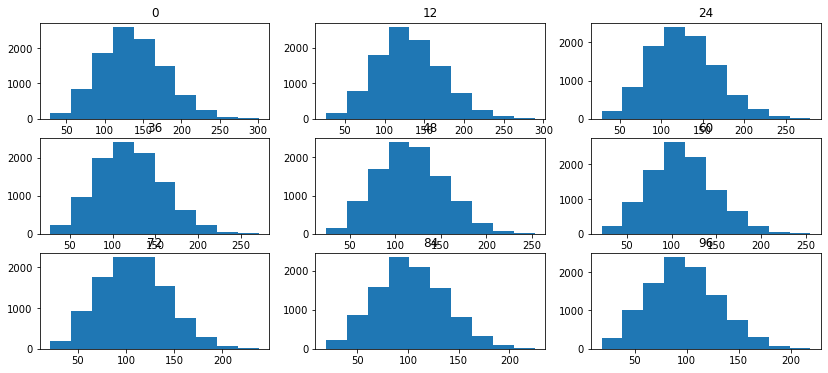

milesFromMetropolis
0     0.264
12    0.281
24    0.288
36    0.310
48    0.233
60    0.270
72    0.238
84    0.231
96    0.272
Name: salary, dtype: float64

In [29]:
miles= np.arange(0, 99+1, 12)
plt.figure(figsize = (14, 6))

# plot histograms
for i in range(len(miles)):
    plt.subplot(3, 3, i+1)
    plt.hist(train_df.salary[train_df.milesFromMetropolis == miles[i]])
    plt.title(miles[i])
plt.show()

train_df.groupby(['milesFromMetropolis']).salary.skew()[miles]

The skewness is the small among all features and skews at similar rate. There's no obvious relationship between skewness and and milesFromMetropolis.

And to show the linearity, here's the plot of milesFromMetropolis vs. average salary.

,count,mean,std,min,25%,50%,75%,max
milesFromMetropolis,,,,,,,,
0,10123.0,135.571,41.097,29.0,106.0,134.0,163.0,301.0
12,10016.0,130.950,40.343,26.0,102.0,128.0,158.0,289.0
24,9854.0,126.404,39.099,28.0,99.0,124.0,152.0,280.0
36,10000.0,120.623,38.141,27.0,93.0,119.0,145.0,271.0
48,10104.0,116.520,36.594,24.0,90.0,115.0,141.0,253.0
60,10018.0,111.564,35.812,22.0,86.0,110.0,135.0,255.0
72,10063.0,107.672,35.004,21.0,83.0,107.0,131.0,238.0
84,9947.0,102.601,34.047,19.0,79.0,101.0,126.0,225.0
96,10090.0,97.225,33.064,18.0,74.0,96.0,119.0,219.0


<AxesSubplot:xlabel='milesFromMetropolis'>

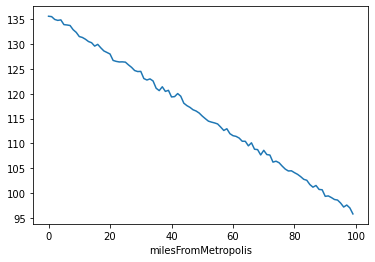

In [30]:
# select random miles and show statistics
miles= np.arange(0, 99+1, 12)
sorted_miles = group_values('milesFromMetropolis', miles)
display(sorted_miles.groupby(['milesFromMetropolis']).salary.describe())

# show milesFromMetropolis vs salary
train_df.groupby(['milesFromMetropolis']).salary.mean().plot(x='milesFromMetropolis', y='salary')

The lins has slope of -0.4 and offset 135.

Similar to yearsExperience, milesFromMetropolis is an independent feature, Gaussian distributed, and has (reversed) linear pattern.

### EDA Conclusion
1. All features are Gaussian distributed and positive skewness


2. Higher average salary often pairs with wider distribution (larger deviation)


3. **companyId** has weak association with salary
    * Has smallest salary variance
    * Correlation with other features might be low, too


4. **jobType** has strong correlation with salary
    * Has highest salary variance: avearage salary ranges from 145 to 70


5. **degree** has strong correlation with salary
    * BACHELORS or advanced degree have much higher salary than HIGH_SCHOOL and NONE
    * Can potentially be split to two groups:
        * NONE and HIGH_SCHOOL: more job opening but lower salary
        * BACHELORS, MASTERS, DOCTORAL: less job openings and higher salary


6. **major**: ENGINEERING and BUSINESS major offer the most, then science majors, and LITERATURE and NONE offer the lowest
    * Has imbalanced data: more than half of training set don't require a major


7. **industry**: FINANCE and OIL offer the most
    * Has smallest skew rate
    * Correlation with salary might be moderate or low


8. **companyId**, **jobType**, **degree**, **major**, and **industry** are not independent features
    * Consider adding group statistics as features to strenthen the feature dependencies
    * Consider adding new feature(s) indicating the outlier upper boundry


9. More **yearsExperience** is offered more salary


10. Less **milesFromMetropolis** is offered more salary


11. **yearsExperience** and **milesFromMetropolis** are independent and linearly related to salary
    * Though salary is linearly associated with these two features, consider converting to mean salary so they have the similar scale as salary and other features
    
    
12. All categories have outliers but in reasonable range and number, so I won't consider removing them.


## Hypothesis Solution
### Data preperation
1. Encode data:
    * Transform categorical values to numerical
    * Transform or scale yearsExperience and milesFromMetropolis to same scale as other features
2. Engineer features:
    * Group dependent features to emphesize dependencies

### Model selection
For model selection, I'll select few regression models and few ensemble models:

For regression models, I'll try the basic **LinearRegrerssion** model. And since the features aren't too diverse, I'm guessing the model shouldn't be too complicated, thus it's not necessary to penalize the model complexity. I'll use **Lasso** and **ElesticNet** modelto check my hypothesis, and I expect no dramatic improvement. I won't consider KNN or SVM because those models will take too much time to train with our data size. And definitely **DecisionTreeRegressor** tree model because our data seems simple enough for binary spliting.

Although ensemble models take long time to train, they're very powerful models. I'll try ensemble tree model such as **RandomForestRegressor** and **ExtraTreeRegressor** and boosting models such as **AdaBoostRegressor** and **GradientBoostingRegressor**.

## Encode Data
The goal is to transform our data according to certain rules to further reveal the hidden pattern.

First, we have to transform strings to meaningful numerical values. companyId, jobType, degree, major, and industry are categorical columns that need convertion. We have three options:
1. One-Hot Encoder: one of the common encoders
2. Categorical Encoder: one of the common encoders
3. Category Average Salary Encoder: use average salary of the category to encode categories

Let's try all three and use 50,000 samples for testing to see which method yields highest correlation with salary.

### One Hot Encoder
In this case, one-hot encoding 50,000 samples takes too long, use 500 samples instead. Also show first 30 out of 95 correlations.

In [25]:
def one_hot_encoder(train, features, test=pd.DataFrame()):
    for feature in features:
        categories = train[feature].unique()
        for category in categories:
            train[feature + "_" + category] = (train[feature] == category).astype(int)
            if test.any().any():
                test[feature + "_" + category] = (test[feature] == category).astype(int)
        train = train.drop(columns=feature)
        if test.any().any():
            test = test.drop(columns=feature)
            
    return train, test

In [26]:
# because one-hot encoding 50,000 samples takes too long, use 5,000 samples instead
examples = 5000
example_set = train_df[:examples].copy()

# display data after encoding
display(one_hot_encoder(example_set, ['jobType', 'degree', 'major', 'industry', 'companyId'])[0].head(5))

# show feature correlation with salary
show_corr = 30
one_hot_encoder(example_set, ['jobType', 'degree', 'major', 'industry', 'companyId'])[0].corr().salary.iloc[:show_corr]

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CEO,jobType_VICE_PRESIDENT,jobType_MANAGER,jobType_JUNIOR,jobType_JANITOR,jobType_CTO,...,companyId_COMP59,companyId_COMP13,companyId_COMP39,companyId_COMP16,companyId_COMP9,companyId_COMP32,companyId_COMP62,companyId_COMP35,companyId_COMP18,companyId_COMP60
jobId,,,,,,,,,,,,,,,,,,,,,
JOB1362684407687,10,83,130,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JOB1362684407688,3,73,101,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JOB1362684407689,10,38,137,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JOB1362684407690,8,17,142,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JOB1362684407691,8,16,163,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


yearsExperience           0.368
milesFromMetropolis      -0.299
salary                    1.000
jobType_CFO               0.171
jobType_CEO               0.275
jobType_VICE_PRESIDENT    0.097
jobType_MANAGER          -0.007
jobType_JUNIOR           -0.178
jobType_JANITOR          -0.457
jobType_CTO               0.201
jobType_SENIOR           -0.106
degree_MASTERS            0.158
degree_HIGH_SCHOOL       -0.195
degree_DOCTORAL           0.236
degree_BACHELORS          0.122
degree_NONE              -0.259
major_MATH                0.110
major_NONE               -0.366
major_PHYSICS             0.092
major_CHEMISTRY           0.071
major_COMPSCI             0.101
major_BIOLOGY             0.058
major_LITERATURE          0.044
major_BUSINESS            0.155
major_ENGINEERING         0.153
industry_HEALTH          -0.005
industry_WEB              0.079
industry_AUTO            -0.063
industry_FINANCE          0.156
industry_EDUCATION       -0.173
Name: salary, dtype: float64

One-Hot encoding is the standard way to transform strings to numericals, but it
1. Too many new features (95 columns)
    * Think of curse of dimensionality
2. Takes too much time to generate
3. Challenging for algorithm to understand

Thus, one-hot encoding isn't the ideal encoder in our case.

### Label Encoder
This method uses sklearn.preprocessing.LabelEncoder() to assign numerical values starting from 0.

In [27]:
def categorical_encoder(train, features, test=pd.DataFrame()):
    encoder = sklearn.preprocessing.LabelEncoder()
    for feature in features:
        train[feature] = encoder.fit_transform(train[feature])
        if test.any().any():
            test[feature] = encoder.transform(test[feature])

    return train, test

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,31,1,3,6,3,10,83,130
JOB1362684407688,11,0,2,7,6,3,73,101
JOB1362684407689,48,7,1,8,3,10,38,137
JOB1362684407690,32,5,1,2,0,8,17,142
JOB1362684407691,60,7,0,8,2,8,16,163


companyId             -0.007
jobType               -0.232
degree                -0.232
major                 -0.265
industry               0.081
yearsExperience        0.374
milesFromMetropolis   -0.299
salary                 1.000
Name: salary, dtype: float64


<AxesSubplot:>

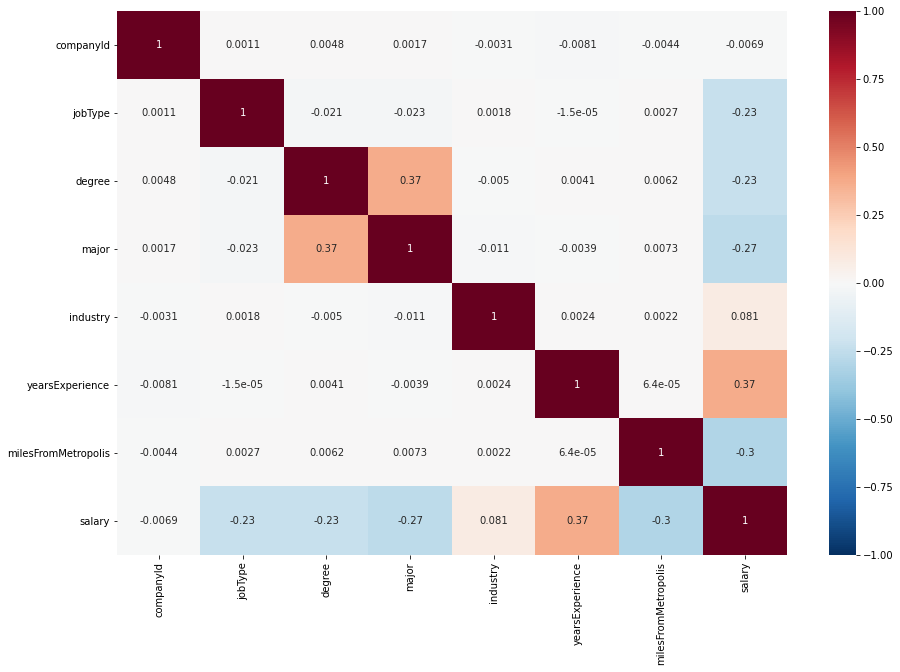

In [28]:
example_set = train_df[:50000].copy()
features = ['jobType', 'degree', 'major', 'industry', 'companyId']

# display data after encoding
display(categorical_encoder(example_set, features)[0].head(5))

# show feature correlation with salary
correlation = categorical_encoder(example_set, features)[0].corr()
print(correlation['salary'])

# plot correlation
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, vmin=-1, cmap="RdBu_r")

With Label Encoder:
1. No new feature
2. Except companyId and industry, other features have good correlation with salary
3. Except major and degree, other pairs of features are independent from each other

This approach looks promissing! Let's see if we can lift the perfomance up a notch with custom Categorical Encoder.

#### Category Average Salary Encoder
This method uses the average salary to assign numerical values.
1. No 0: I don't want to confuse or deactivate any category with 0
2. Average salaries indicates the ranking of categories
3. Average salaries are the same scale as salary
4. Not only categorical columns, numerical columns (yearsExperience and milesFromMetropolis) can also be converted to average salary since there aren't many different unique numbers (0-24 years and 0-99 miles)

In [29]:
def average_salary_encoder(train, features, test=pd.DataFrame()):
    for feature in features:
        salary_dict = dict(train.groupby([feature]).salary.mean())
        train[feature] = train[feature].map(salary_dict)
        if test.any().any():
            test[feature] = test[feature].map(salary_dict)

    return train, test

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,115.585,135.086,130.519,132.946,116.389,10,83,130
JOB1362684407688,114.863,145.338,101.544,102.470,120.974,3,73,101
JOB1362684407689,115.230,124.825,135.313,129.939,116.389,10,38,137
JOB1362684407690,115.229,114.445,135.313,129.139,109.767,8,17,142
JOB1362684407691,114.497,124.825,125.494,129.939,130.004,8,16,163


companyId              0.040
jobType                0.597
degree                 0.404
major                  0.380
industry               0.295
yearsExperience        0.374
milesFromMetropolis   -0.299
salary                 1.000
Name: salary, dtype: float64


<AxesSubplot:>

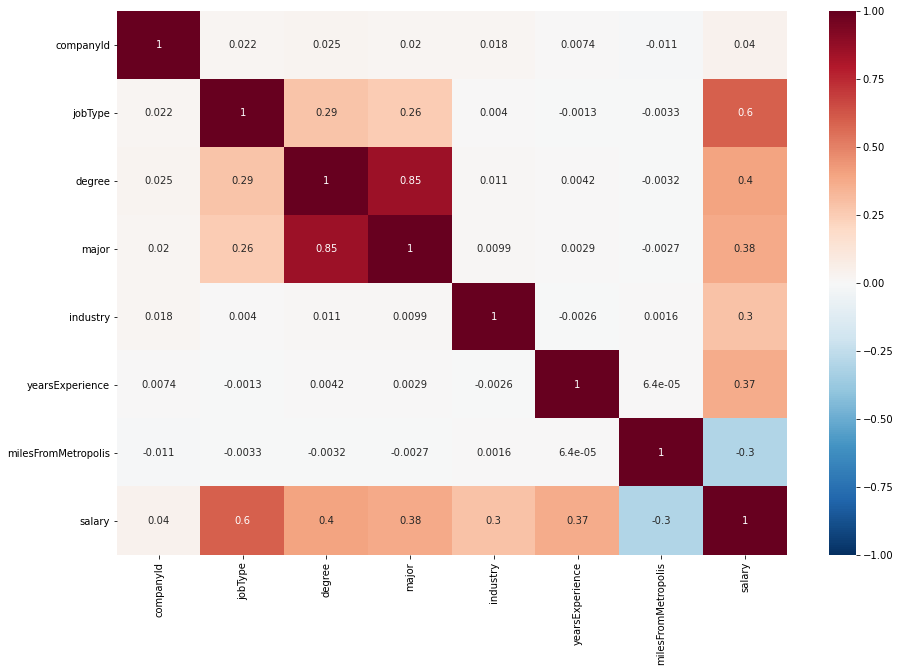

In [30]:
example_set = train_df[:50000].copy()
features = ['jobType', 'degree', 'major', 'industry', 'companyId']

# display data after encoding
display(average_salary_encoder(example_set, features)[0].head(5))

# show feature correlation with salary
correlation = average_salary_encoder(example_set, features)[0].corr()
print(correlation.salary)

# plot correlation
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, vmin=-1, cmap="RdBu_r")

From correlation matrix, we observe:
1. Correlation matrix of custom Label Encoder looks like correlation matrix of Label Encoder but better
2. Between Salary and other features, only companyId has low correlation with salary
    * Consider removing companyId
3. Between feature to feature, Major and Industry are highly correlated.
    * Consider merging Major and Industry to avoid possible noise
4. Between two features, pairs other than Major-Industry have low correlation, meaning two features are relatively independent from each other

Thus makes it the plausible encoder for our case.

## Engineer Feature
Now we've selected our encoder, next is feature engineering. From the correlation matrix with average salary encoder, we see some potential options for feature selection:
1. Group dependent features
2. Drop companyId
3. Add statistical values
4. Remove outliers

Following is the best feature engineering method I tried:

In [31]:
def group_k_columns(train, features, col_name="group", test=pd.DataFrame()):
    group = train.groupby(features).salary
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    salary_dictionaries = []
#     salary_dictionaries.append(dict(lower_bound,    name = col_name + "_lower"))
    salary_dictionaries.append(dict(group.min(),    name = col_name + "_min"))
    salary_dictionaries.append(dict(Q1,             name = col_name + "_Q1"))
    salary_dictionaries.append(dict(group.mean(),   name = col_name + "_mean"))
    salary_dictionaries.append(dict(group.median(), name = col_name + "_median"))
    salary_dictionaries.append(dict(Q3,             name = col_name + "_Q3"))
    salary_dictionaries.append(dict(upper_bound,    name = col_name + "_upper"))
    salary_dictionaries.append(dict(group.max(),    name = col_name + "_max"))
    
    for dictionary in salary_dictionaries:
        salary = []
        for index in train.index:
            combination = tuple(train.loc[index, features])
            salary.append(dictionary[combination])
        train[dictionary['name']] = pd.Series(salary, index=train.index)

        if test.any().any():
            salary = []
            for index in test.index:
                combination = tuple(test.loc[index, features])
                if combination in dictionary:
                    salary.append(dictionary[combination])
                else:
                    salary.append(np.NaN)
            salary_series = pd.Series(salary, index=test.index)
            salary_series.fillna(salary_series.mean(), inplace=True)
            test[dictionary['name']] = salary_series
        
    return train, test

In [32]:
def feature_engineer(train, features, col_name, test=pd.DataFrame()):
    train, test = average_salary_encoder(train, features, test)
    train, test = group_k_columns(train, features, col_name, test)

    return train, test

Let's test the correlation after feature engineering:

companyId              0.008
jobType                0.597
degree                 0.401
major                  0.379
industry               0.297
yearsExperience        0.375
milesFromMetropolis   -0.298
salary                 1.000
CJDMI_min              0.698
CJDMI_Q1               0.738
CJDMI_mean             0.755
CJDMI_median           0.744
CJDMI_Q3               0.740
CJDMI_upper            0.637
CJDMI_max              0.587
Name: salary, dtype: float64


<AxesSubplot:>

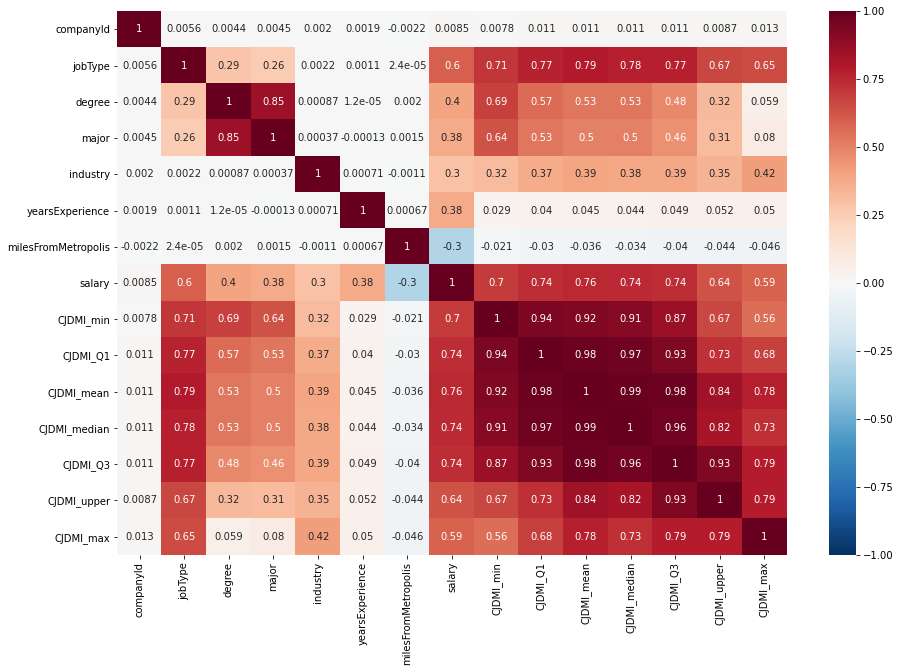

In [33]:
features = ['companyId', 'jobType', 'degree', 'major', 'industry']
stat_col_name = 'CJDMI'
correlation = feature_engineer(train_df.copy(deep=True), features, stat_col_name)[0].corr()

print(correlation.salary)

plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, vmin=-1, cmap="RdBu_r")

## Create Models
Create multiple models and try scaling, tuning, and finally pick best model for prediction. Use MSE as performance metrics.
### Baseline model
Create a naive model and measure MSE as my performance metrics baseline. Here I use industry average salary as my baseline model.

In [34]:
industry_dict = dict(train_df.groupby(['industry']).salary.mean())
baseline_true = train_df.salary.values.astype(float)
baseline_pred = train_df.industry.map(industry_dict)

mse = mean_squared_error(baseline_true, baseline_pred)
mae = mean_absolute_error(baseline_true, baseline_pred)
print("Baseline: MSE=%.3f\tMAE=%.3f" % (mse, mae))

Baseline: MSE=1367.123	MAE=29.672


### Vanilla Regression and ensamble models
Try vanilla models and pick couple of models with low MSE for further tuning.

In [35]:
features = ['companyId', 'jobType', 'degree', 'major', 'industry']
stat_col_name = 'CJDMI'
train = feature_engineer(train_df.copy(), features, stat_col_name)[0]

model_list = [('LR', LinearRegression()),
              ('LASSO', Lasso()), 
              ('EN', ElasticNet()), 
              ('CART', DecisionTreeRegressor()),
              ## Boosting
              ('AB', AdaBoostRegressor()), 
              ('GBR', GradientBoostingRegressor()), 
              ## Bagging
              ('RF', RandomForestRegressor()), 
              ('ET', ExtraTreesRegressor())]

for name, model in model_list:
    scores = sklearn.model_selection.cross_val_score(model, train.drop(columns='salary'), train.salary, scoring='neg_mean_squared_error')
    print("%s:\tMSE=%.3f" % (name, -1.0 * np.mean(scores)))

LR:	MSE=351.652


C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125597.58765864372, tolerance: 119846.70566935067
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123587.94905030727, tolerance: 119856.9693130074
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123950.94189035892, tolerance: 119845.16673019736
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increas

LASSO:	MSE=351.725


C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217740.87890934944, tolerance: 119846.70566935067
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224161.04614531994, tolerance: 119856.9693130074
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203609.82840883732, tolerance: 119845.16673019736
  positive)
C:\Users\jenny\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increas

EN:	MSE=351.727
CART:	MSE=652.002
AB:	MSE=455.022
GBR:	MSE=328.327
RF:	MSE=337.152
ET:	MSE=343.122


Ensemble models performs better in general, and GradientBoostingRegressor performs the best. Besides GradientBoostingRegressor, pick couple other models that have low MSE: RandomForestRegressor, ExtraTreesRegressor, and LinearRegression. Tune hyperparameters and try other adjustments to improve performance.

### Scaling

In [36]:
train = feature_engineer(train_df.copy(), ['companyId', 'jobType', 'degree', 'major', 'industry'], 'CJDMI')[0]

model_list = [("scaledLR",  Pipeline([("Scaler", StandardScaler()), ("LR",  LinearRegression())])),
              ("scaledRF",  Pipeline([("Scaler", StandardScaler()), ("RF",  RandomForestRegressor())])),
              ("scaledGBR", Pipeline([("Scaler", StandardScaler()), ("GBR", GradientBoostingRegressor())])),
              ("scaledET",  Pipeline([("Scaler", StandardScaler()), ("ET",  ExtraTreesRegressor())]))]

for name, model in model_list:
    scores = sklearn.model_selection.cross_val_score(model, train.drop(columns='salary'), train.salary, scoring='neg_mean_squared_error')
    print("%s:\tMSE=%.3f" % (name, -1.0 * np.mean(scores)))

scaledLR:	MSE=351.652
scaledRF:	MSE=337.228
scaledGBR:	MSE=328.327
scaledET:	MSE=343.046


Standardize the data doesn't improve the performance. Let's try tuning hyperparameters.

### Grid Searching
Use grid search to find best hyperparameters
#### Random Forest Regressor

In [37]:
train = feature_engineer(train_df.copy(), ['companyId', 'jobType', 'degree', 'major', 'industry'], 'CJDMI')[0]

for n_est in [50, 100, 200]:
    for depth in [10, 15]:
        for features in [8, 10]:        
            model = RandomForestRegressor(n_estimators=n_est, max_depth=depth, max_features=features)
            scores = sklearn.model_selection.cross_val_score(model, train.drop(columns='salary'), train.salary, scoring='neg_mean_squared_error')
            print("(%d, %s, %.3f):\tMSE=%.3f" % (n_est, depth, features, -1.0 * np.mean(scores)))

            model.fit(train.drop(columns='salary'), train.salary)
            feature_importance = model.feature_importances_
            for i in range(len(feature_importance)):
                print("%s\t%.6f" % (train.drop(columns='salary').columns[i], feature_importance[i]))
            print()    

(50, 10, 8.000):	MSE=320.327
companyId	0.000023
jobType	0.000127
degree	0.000823
major	0.000188
industry	0.000092
yearsExperience	0.151778
milesFromMetropolis	0.099487
CJDMI_min	0.023643
CJDMI_Q1	0.057633
CJDMI_mean	0.394215
CJDMI_median	0.185675
CJDMI_Q3	0.074135
CJDMI_upper	0.001242
CJDMI_max	0.010942

(50, 10, 10.000):	MSE=319.456
companyId	0.000014
jobType	0.000089
degree	0.001032
major	0.000203
industry	0.000067
yearsExperience	0.153183
milesFromMetropolis	0.100387
CJDMI_min	0.014919
CJDMI_Q1	0.032470
CJDMI_mean	0.470877
CJDMI_median	0.179294
CJDMI_Q3	0.034171
CJDMI_upper	0.000745
CJDMI_max	0.012547

(50, 15, 8.000):	MSE=314.822
companyId	0.003951
jobType	0.003181
degree	0.002165
major	0.002002
industry	0.002202
yearsExperience	0.148456
milesFromMetropolis	0.102563
CJDMI_min	0.013592
CJDMI_Q1	0.055020
CJDMI_mean	0.373997
CJDMI_median	0.153008
CJDMI_Q3	0.116578
CJDMI_upper	0.006294
CJDMI_max	0.016992

(50, 15, 10.000):	MSE=315.063
companyId	0.004202
jobType	0.002301
degree	0.002396

Although MSE still decreases with n_estimators, but it'll take too long to train so I'm taking MSE=313.741 as best score from model RandomForestRegressor(n_estimators=200, max_depth=15, max_features=8).

#### Gradient Boosting Regressor

In [39]:
train = feature_engineer(train_df.copy(), ['companyId', 'jobType', 'degree', 'major', 'industry'], 'CJDMI')[0]

for n_est in [50, 100, 200]:
    for loss in ['ls', 'huber']:
        for depth in [8, 15]:
            model = GradientBoostingRegressor(n_estimators=n_est, loss=loss, max_depth=depth)
            scores = sklearn.model_selection.cross_val_score(model, train.drop(columns='salary'), train.salary, scoring='neg_mean_squared_error')
            print("(%d, %s, %.3f):\tMSE=%.3f" % (n_est, loss, depth, -1.0 * np.mean(scores)))

            model.fit(train.drop(columns='salary'), train.salary)
            feature_importance = model.feature_importances_
            for i in range(len(feature_importance)):
                print("%s\t%.6f" % (train.drop(columns='salary').columns[i], feature_importance[i]))
            print()

(50, ls, 8.000):	MSE=308.098
companyId	0.000063
jobType	0.003245
degree	0.002764
major	0.000816
industry	0.001763
yearsExperience	0.152174
milesFromMetropolis	0.104708
CJDMI_min	0.008659
CJDMI_Q1	0.032319
CJDMI_mean	0.661125
CJDMI_median	0.006515
CJDMI_Q3	0.007942
CJDMI_upper	0.001570
CJDMI_max	0.016336

(50, ls, 15.000):	MSE=332.870
companyId	0.009975
jobType	0.005010
degree	0.004186
major	0.003961
industry	0.004867
yearsExperience	0.142077
milesFromMetropolis	0.107928
CJDMI_min	0.014775
CJDMI_Q1	0.041291
CJDMI_mean	0.598602
CJDMI_median	0.014368
CJDMI_Q3	0.016763
CJDMI_upper	0.011810
CJDMI_max	0.024387

(50, huber, 8.000):	MSE=309.350
companyId	0.000043
jobType	0.003173
degree	0.001934
major	0.000618
industry	0.001596
yearsExperience	0.150124
milesFromMetropolis	0.101087
CJDMI_min	0.010961
CJDMI_Q1	0.035688
CJDMI_mean	0.669086
CJDMI_median	0.009203
CJDMI_Q3	0.008246
CJDMI_upper	0.001630
CJDMI_max	0.006610

(50, huber, 15.000):	MSE=332.962
companyId	0.009856
jobType	0.004890
degree	0.

In general:
* n_estimators=100 < n_estimators=200 < n_estimators=50
* loss='ls' MSE < loss='huber' MSE
* max_depth=8 MSE < max_depth=15

And the best model is GradientBoostingRegressor(n_estimators=100, loss='ls', max_depth=8) with MSE=306.792, and also the best model compare to RandomForesetRegressor.

## Deploy solution

In [88]:
train, test = feature_engineer(train_df.copy(), ['companyId', 'jobType', 'degree', 'major', 'industry'], 'CJDMI', test_df.copy())

model = GradientBoostingRegressor(n_estimators=100, loss='ls', max_depth=8)
model.fit(train.drop(columns='salary'), train.salary)
test_pred = model.predict(test).round(3)
test_final = pd.DataFrame(test_pred, index=test_df.index, columns=['salary'])
test_final.to_csv("test_salaries_prediction.csv")